In [1]:
import wfdb
import matplotlib.pyplot as plt
import scipy.signal
import numpy as np
import copy
import os
import seaborn as sns

In [2]:
sampfrom = 1300
#samp, rinfo = wfdb.rdsamp("data/drive12", channels=[0], sampfrom=sampfrom, sampto=sampfrom+100)
samp, rinfo = wfdb.rdsamp("data/drive12", channels=None, sampfrom=sampfrom, sampto=sampfrom+100)
samp = samp.flatten()

In [3]:
rinfo

{'fs': 15.5,
 'sig_len': 100,
 'n_sig': 7,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV', 'mV', 'mV', 'bpm', 'mV', 'mV'],
 'sig_name': ['ECG', 'EMG', 'foot GSR', 'hand GSR', 'HR', 'marker', 'RESP'],
 'comments': []}

In [4]:
def load_data(filename, channels=[0], sampfrom=0, sampto=1000):
    samp, rinfo = wfdb.rdsamp(filename, channels=channels, sampfrom=sampfrom, sampto=sampto)
    samp = samp.flatten()
    sr = rinfo["fs"]
    return sr, samp

def load_drive(n, channels=[0], sampfrom=0, sampto=1000):
    name = "drive%s" % str(n).zfill(2)
    filepath = os.path.join("data", name)
    return load_data(filepath, channels=channels, sampfrom=sampfrom, sampto=sampto)

def detect_peaks(X, N=5, area=3, rthreshold=50, pthreshold=90, do_plot=False):
    # N = 5 # N per seg
    
    # STFT
    WS = (N//2)+1 # Window samples
    f, t, Zxx = scipy.signal.stft(X, nperseg=N, noverlap=0)
    Zxx = np.abs(Zxx).reshape(-1, WS)
    
    # Detect RoIs
    wmax = np.max(Zxx, axis=1)
    thresholdF = np.percentile(wmax, rthreshold) #Nth percentile
    intervals = t[wmax > thresholdF]
    
    # Detect peaks
    thresholdP = np.percentile(X, pthreshold)
    peaks = []
    #area = 3 # additional search area aroud region
    for base in intervals.astype(int):
        if base >= X.size:
            continue
        if base > WS+area:
            base = base-WS-area
        end = base + N + area*2
        window = X[base:end]
        imax = np.max(window)
        if imax > thresholdP:
            peakT = base + np.argmax(window)
            if peakT in peaks:
                continue
            peaks.append(peakT)
    
    # Plot RoIs and peaks
    if do_plot:
        xmin = np.min(X)
        xmax = np.max(X)      
        plt.plot(X, linewidth=5, label="ECG")
        plt.vlines(intervals-WS-area, ymin=xmin, ymax=xmax, color="g", linewidth=0.5, label="roi start")
        plt.vlines(intervals+N+area*2, ymin=xmin, ymax=xmax, color="b", linewidth=0.5, label="roi end")
        plt.vlines(peaks, ymin=xmin, ymax=xmax, color="r", label="peak")
        plt.legend()
    
    return peaks

def trim_to_peak(X, sr, fail=True):
    sr = int(sr)
    peaks = detect_peaks(X[:sr*2])
    if not peaks and not fail:
        # If R peak not detected trim to max value in sr*2 interval
        print("No R peak detected -> trimming to max value in sr*2 interval")
        imax = np.argmax(X[:sr*2])
        return X[imax:]
    elif not peaks and fail:
        raise Exception("No peak detected")
        #return None
    peak = peaks[0]
    return X[peak:]

def resample(X, sr, tsr, trim=False):
    rate = tsr / sr
    xsize = X.size
    num = int(xsize * rate)
    rX = scipy.signal.resample(X, num)
    if trim:
        return rX[:xsize]
    return rX

def pair_signals(signals, srs):
    signals = copy.deepcopy(signals)
   
    # Resampling
    sr = srs[0]
    # Need to resample
    if np.min(srs) != np.max(srs):
        imaxsr = np.argmax(srs)
        maxsr = srs[imaxsr]
        sr = maxsr
        
        for i, (signal, ssr) in enumerate(zip(signals, srs)):
            print("Resampling %s" % i)
            if ssr == maxsr:
                continue
            rsignal = resample(signal, ssr, maxsr, trim=True)
            signals[i] = rsignal
            
    # R peak trim
    for i, (signal, ssr) in enumerate(zip(signals, srs)):
        print("Peak trimming %s" % i)
        signals[i] = trim_to_peak(signal, ssr, fail=False)
    
    # Resizing
    sizes = [s.size for s in signals]
    size = sizes[0]
    # Need to resize
    if np.min(sizes) != np.max(sizes): 
        iminsize = np.argmin(sizes)
        minsize = sizes[iminsize]
        size = minsize
        
        for i, (signal, size) in enumerate(zip(signals, sizes)):
            if size == minsize:
                continue
            print("Resizing %s" % i)
            signals[i] = signal[:minsize]
    
    return signals, sr, size

def rectify(s1):
    return np.abs(emg)

def integrate(s1, window_size):
    return np.convolve(remg, np.ones(window_size), mode="same")

def detect_changes(s1, window_size, threshold=0.01, do_plot=False):
    ts1 = s1[:s1.size - s1.size%window_size]
    
    changes = []
    for i, window in enumerate(np.split(ts1, ts1.size / window_size)):
        base = i * window_size
        end = (i+1) * (window_size) - 1

        grad = np.gradient(window)
        grad = np.sum(grad)

        if grad > threshold:
            changes.append( (base, end, True) )
            #plt.axvspan(base, end, color="green", alpha=0.5)
        elif grad < -threshold:
            changes.append( (base, end, False) )
            #plt.axvspan(base, end, color="red", alpha=0.5)
            
    if do_plot:
        plt.plot(ts1)
        for (base, end, rising) in changes:
            color = "green" if rising else "red"
            plt.axvspan(base, end, color=color, alpha=0.5)
            
    return changes

# Task 1 - heartrate detection

In [5]:
sr, signal = load_drive(12, sampfrom=0, sampto=250)

In [6]:
seconds = signal.size / sr
seconds

16.129032258064516

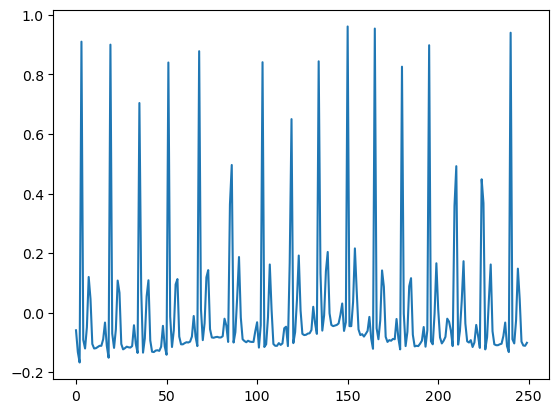

In [7]:
plt.plot(signal)

19
70.67999999999999


[]

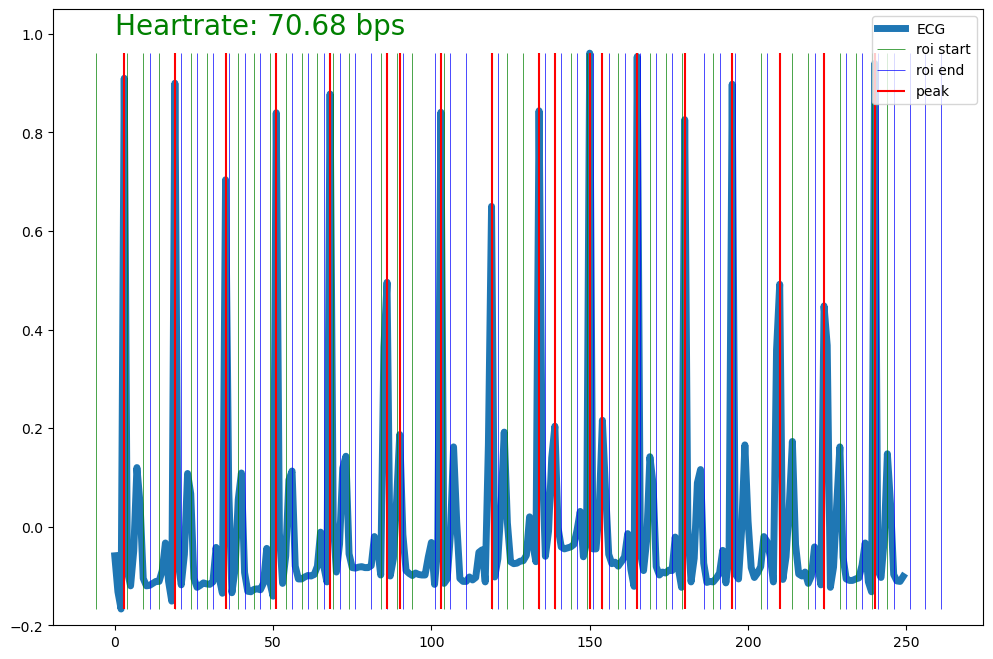

In [8]:
plt.figure(figsize=(12, 8))
peaks = detect_peaks(signal, N=5, rthreshold=20, pthreshold=90, do_plot=True)
npeaks = len(peaks)
print(npeaks)
pps = npeaks / seconds
hr = pps*60
print(hr)
plt.text(0, 1, "Heartrate: %.2f bps" % hr, fontdict={"size": 20, "color": "green"})
plt.ylim(-0.2, 1.05)
plt.legend(loc="upper right")
plt.plot()

In [9]:
def test_peak_detection(file, sampfrom=0, nsamp=100000, correct_threshold=0.0001):
    samp, rinfo = wfdb.rdsamp(file, channels=None, sampfrom=sampfrom, sampto=sampfrom+nsamp)
    ann = wfdb.rdann(file, extension="atr", sampfrom=sampfrom, sampto=sampfrom+nsamp)
    samp = samp[:, 0]
    sr = rinfo["fs"]
    
    peaks = detect_peaks(samp, N=int(sr/3), area=int(sr/6), rthreshold=20, pthreshold=90)
    
    threshold = correct_threshold
    total = ann.sample.size
    correct = 0
    wrong = 0
    for peak in peaks:
        detected = False
        for true_peak in ann.sample:
            delta = (true_peak+1) / (peak+1)
            deltap = np.abs(1-delta)
            if deltap < threshold:
                detected = True
                break

        if detected:
            correct += 1
        else:
            wrong += 1

    #print(correct, total, correct / total)
    #print(wrong)
    
    return correct, wrong, total, len(peaks)

In [10]:
percentages = []

for file in os.listdir("nsrdb"):
    if not file.endswith(".dat"):
        continue

    file = os.path.join("nsrdb", file.replace(".dat", ""))
    correct, wrong, total, detected_total = test_peak_detection(file)
    percent = correct / total
    percentages.append(percent)

    msg = "%s: correct peaks: %.3f %% correct: %s wrong: %s correct total: %s detected total: %s" % (
        file, percent*100, correct, wrong, total, detected_total)
    print(msg)
    
print("Average correct: %.3f %%" % (np.average(percentages)*100))

nsrdb/16539: correct peaks: 83.288 % correct: 912 wrong: 175 correct total: 1095 detected total: 1087
nsrdb/16265: correct peaks: 72.058 % correct: 949 wrong: 178 correct total: 1317 detected total: 1127
nsrdb/16795: correct peaks: 59.207 % correct: 627 wrong: 581 correct total: 1059 detected total: 1208
nsrdb/18184: correct peaks: 62.948 % correct: 756 wrong: 341 correct total: 1201 detected total: 1097
nsrdb/16786: correct peaks: 66.805 % correct: 644 wrong: 526 correct total: 964 detected total: 1170
nsrdb/16272: correct peaks: 68.305 % correct: 681 wrong: 504 correct total: 997 detected total: 1185
nsrdb/19088: correct peaks: 56.553 % correct: 781 wrong: 311 correct total: 1381 detected total: 1092
nsrdb/16420: correct peaks: 64.471 % correct: 744 wrong: 282 correct total: 1154 detected total: 1026
nsrdb/17453: correct peaks: 81.625 % correct: 844 wrong: 229 correct total: 1034 detected total: 1073
nsrdb/19090: correct peaks: 77.178 % correct: 886 wrong: 214 correct total: 1148 det

# Task 2 - ECG correlation

In [11]:
drives = range(1, 12+1)
signals = []
srs = []
for drive in drives:
    sr, s = load_drive(drive)
    signals.append(s)
    srs.append(sr)

In [12]:
signals, sr, size = pair_signals(signals, srs)
signals = np.array(signals)

Resampling 0
Resampling 1
Resampling 2
Resampling 3
Resampling 4
Resampling 5
Resampling 6
Resampling 7
Resampling 8
Resampling 9
Resampling 10
Resampling 11
Peak trimming 0
Peak trimming 1
Peak trimming 2
Peak trimming 3
Peak trimming 4
Peak trimming 5
Peak trimming 6
Peak trimming 7
Peak trimming 8
Peak trimming 9
Peak trimming 10
Peak trimming 11
Resizing 0
Resizing 1
Resizing 2
Resizing 3
Resizing 4
Resizing 6
Resizing 7
Resizing 8
Resizing 9
Resizing 10
Resizing 11


In [13]:
cor_matrix = np.corrcoef(signals)
cor_matrix[np.round(cor_matrix, 4) == 1] = np.nan

In [14]:
minc_i = np.nanargmin(np.abs(cor_matrix)) // 12
minc_j = np.nanargmin(np.abs(cor_matrix)) % 12

maxc_i = np.nanargmax(np.abs(cor_matrix)) // 12
maxc_j = np.nanargmax(np.abs(cor_matrix)) % 12

print("Lowest correlation between drive %s and %s" % (minc_i + 1, minc_j + 1))
print("Greatest correlation between drive %s and %s" % (maxc_i + 1, maxc_j + 1))

Lowest correlation between drive 8 and 9
Greatest correlation between drive 1 and 4


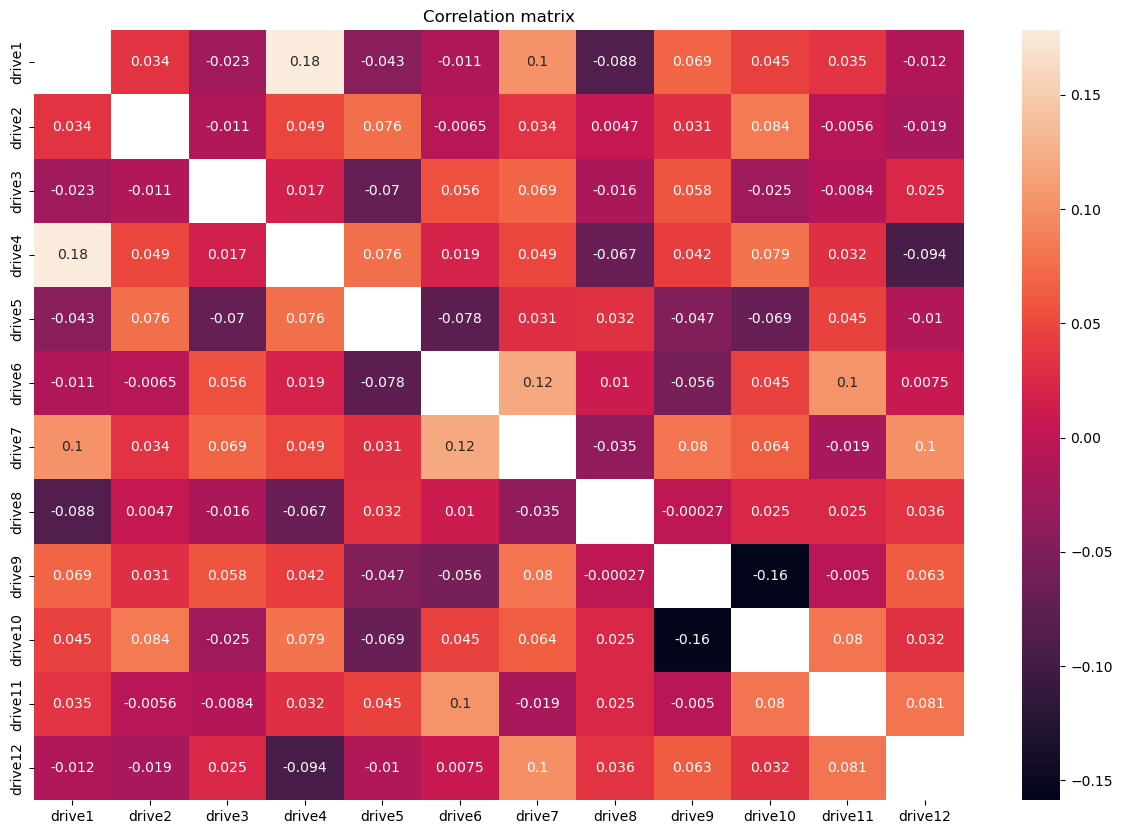

In [15]:
plt.figure(figsize=(15, 10))
plt.title("Correlation matrix")

sns.heatmap(cor_matrix, annot=True,
           xticklabels=list(map(lambda x: "drive%s" % x, range(1, 12+1))),
           yticklabels=list(map(lambda x: "drive%s" % x, range(1, 12+1))),
           )

plt.show()

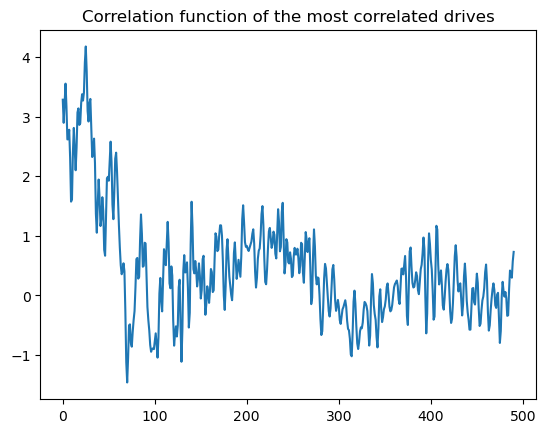

In [16]:
# Greatest correlation drives CF

s1 = signals[maxc_j]
s2 = signals[maxc_i]

CF = scipy.signal.correlate(s1, s2, mode="same")
CF = np.array_split(CF,2)[1]

plt.title("Correlation function of the most correlated drives")
plt.plot(CF)
plt.show()

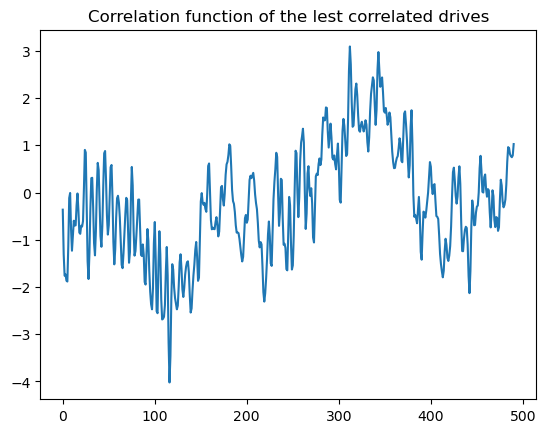

In [17]:
# Lowest correlation drives CF

s1 = signals[minc_j]
s2 = signals[minc_i]

CF = scipy.signal.correlate(s1, s2, mode="same")
CF = np.array_split(CF,2)[1]

plt.title("Correlation function of the lest correlated drives")
plt.plot(CF)
plt.show()

# Task 3 - EMG change detection

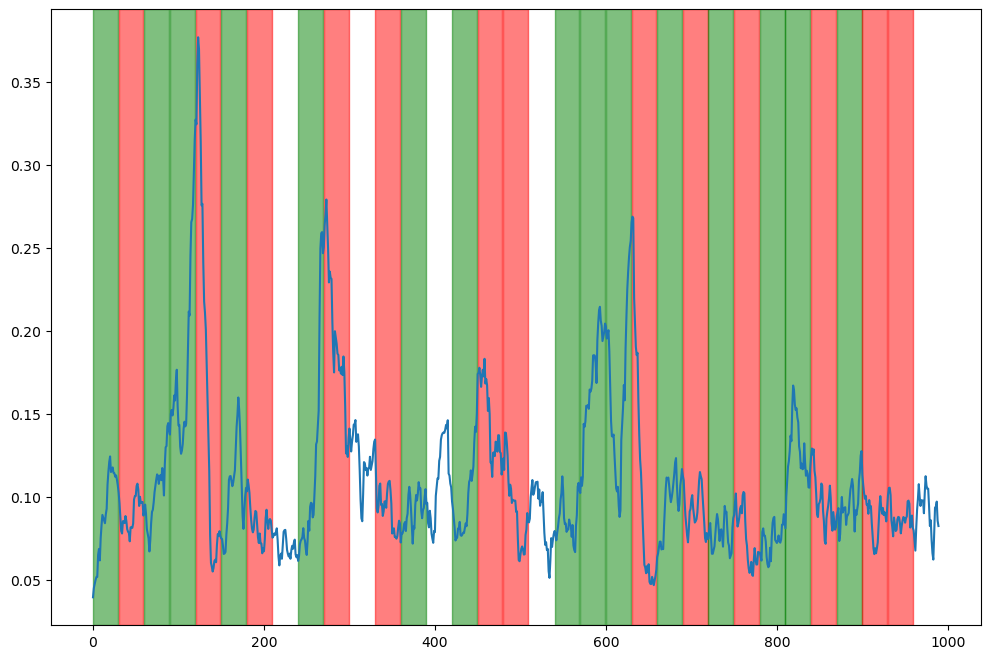

In [18]:
sr, emg = load_drive(1, channels=[1])
# Rectify
remg = rectify(emg)
# Integrate
iremg = integrate(remg, int(sr))

plt.figure(figsize=(12, 8))
_ = detect_changes(iremg, int(sr)*2, do_plot=True)